
# Computing the transfer functions for the FPAsim

## Laurent @IRAP

----

This Notebook builds the content of the default FPAsim memories. 
The characteristics are exported to text files and can be plotted.

----

* Created 30/09/2021
* Modified on 02/05/2023
    * Notebook updated to shift the AMP SQUID transfer function by half a period
* Modified on 13/01/2023
    * Notebook updated to export the transfer functions to ascii files
* Modified on 31/01/2023
    * Addition of TES transfer function
    * Addition of TES steady state
    * Addition of MUX SQUID offset
    * File name updated
* Modified on 11/07/2023
    * AMP SQUID transfer function updated to be signed
    * SQUID transfer function tool modified to specify a FSR and an offset
    * Plot tool modified to specify the Ylimits
* Modified on 30/08/2023
    * SQUID transfer function updated to be continuous betwwen 2 periods
* Modified on 18/09/2023
    * Update to compute a linear TES response (for tests)

----


In [67]:
###################################################
# imports
###################################################

import numpy as np
import matplotlib.pyplot as plt

In [68]:
###################################################
# decimal to hexa converter
###################################################

def dec_to_signed_hexa(value, ndigits):
    r"""
    This function returns the hexadecimal string of a signed decimal value.
    
    Parameters
    ----------
    value : int
        The decimal value to be converted
    ndigits : number
        The number of digits of the data

    Output
    ------
    result : string
        The converted value

    Examples
    --------
    >>> dec_to_signed_hexa(2,1)                                                           
    '2'
    >>> dec_to_signed_hexa(2,3)                                                          
    '002'
    >>> dec_to_signed_hexa(11,4)                                                          
    '000b'
    >>> dec_to_signed_hexa(-2,4)                                                         
    'fffe'
    """

    if value >= 0:
        result = value
    else:
        result = 2**(4*ndigits) + value 
 
    return('{0:0{1}x}'.format(result, ndigits))

In [69]:
###################################################
# TES transfer function
###################################################

def tes(npts, os_factor, nbits = 16, plot=False):

    # Trise / Tfall at L for LPA2.5A pixel
    taurise=52.75e-6
    taufall=785.35e-6

    npts_os = npts * os_factor

    f_frame = 183e3
    f_sampling = f_frame * os_factor
    t_os = np.arange(npts_os) / f_sampling

    maxi = 2**nbits -1

    pulse = np.zeros(len(t_os))
    pulse += -np.exp(-t_os/taurise)+np.exp(-t_os/taufall)
    pulse = pulse * maxi / pulse.max()

    if plot:
        plt.plot(t_os, pulse)
        
    return(t_os, np.round(pulse).astype(int))

In [70]:
###################################################
# TES steady state
###################################################

def tes_steady_state(ntes, nbits, ratio):
    
    steady = np.ones(ntes)*(2**nbits-1)*ratio
    
    return(np.round(steady).astype(int))
    

In [71]:
###################################################
# MUX SQUID tranfer function (SQUID MUX19a Type 3)
###################################################

def mux_squid(npts, nbits=16, FS=0.5, mini=0):        

    # Computing the SQUID transfer function    
    a = np.array([2.40329e-06, 9.54011e-06])
    p = np.array([6.299441, -0.94834025, 0.39483974])

    # Computing one extra point (+1) to check the continuity from 
    # one period to the other
    x = np.arange(npts+1)/npts
    y = (a[0]*np.sin(p[0]*(x+p[1])+p[2]*np.sin(p[0]*(x+p[1])))+a[1])*1e6

    # ICI COMMENCE UN PETIT ESPACE BRICOLAGE...
    # The fit used in this function is such that the function is not 
    # continuous when appending several periods.
    # Here we apply a slope correction to force the last value 
    # of the period to be equal to the first one.
    
    ratio = y[-1] / y[0]
    slope_correction = 1 + (ratio - 1) * np.arange(npts+1)/npts
    y = y / slope_correction    
    
    # scaling the function (6209)
    #y = ((y-(y.max()+y.min())/2)*(2**nbits-1)/(y.max()-y.min()) + offset*(2**nbits-1)) * FS
    y = mini + (y-y.min())*(2**nbits-1)/(y.max()-y.min()) * FS

    y = np.floor(y).astype(int)

    return (x[:-1], y[:-1])


In [72]:
###################################################
# Linear tranfer functions
###################################################

def tf_linear(npts, nbits=16, signed=True):        
    
    x = np.arange(npts)/npts
    y = x

    y = (y-y.min())*(2**nbits-1)/(y.max()-y.min())

    y = np.round(y).astype(int)
    
    if signed:
        y -= 2**(nbits-1)
        
    return (x, y)


In [73]:
###################################################
# MUX SQUID offset
###################################################

def mux_squid_offset(nmuxsq):
    
    offset = np.zeros(nmuxsq)
    
    return(np.round(offset).astype(int))


In [74]:
###################################################
# Doing plot
###################################################

def plot_squid_tf(x, tf, title, plot_file_name, ymin=-2**16, ymax=2**16):
    
    fig=plt.figure(figsize=(11,7))
    ax1=fig.add_subplot(1,1,1)

######
    ax1.plot(x, tf, color='b', linewidth=5, label='Single period')
    ax1.plot(x+1, tf,'--', color='b', linewidth=2, label='Full characteristic')
    ax1.set_xlabel('SQUID flux ($\Phi_0$)')
    ax1.set_ylabel('SQUID output ($\mu V$)')
    ax1.set_xlim(0,2)
    ax1.set_ylim(ymin,ymax)
    ax1.set_title(title, color='blue')
    ax2 = ax1.twiny()
    ax2.set_xlim(0, 2*len(x))
    ax2.set_xlabel("Memory addresses")
    ax1.legend(loc='best')
    ax1.title.set_weight('bold')
    ax1.title.set_fontsize(16)
    for item in ([ax1.xaxis.label, ax1.yaxis.label, ax2.xaxis.label]):
        item.set_weight('bold')
        item.set_fontsize(12)
    for item in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_xticklabels()):
        item.set_fontsize(12)
    ax1.grid()
    fig.tight_layout()

    plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')


In [75]:
###################################################
# Printing hexa values to a text file
###################################################

def tf_to_file(tf, word_length_in_bits, file_name):
    f = open(file_name, 'w')
    
    # Printing first address
    ndigits_address = int(np.ceil(np.log10(len(tf))/np.log10(16)))
    f.write("@" + dec_to_signed_hexa(0, ndigits_address))

    # Printing successive data    
    ndigits_data = int(np.ceil(word_length_in_bits/4))
    for i in range(len(tf)):
        f.write("\n" + dec_to_signed_hexa(tf[i], ndigits_data))
 
    f.close()

In [76]:
###################################################
# Printing integer values to an excel file
###################################################

def tf_to_xls(tf, workbook_name):

    from openpyxl import Workbook, load_workbook

    # create a workbook and one worksheet
    wb = Workbook()
    ws = wb.active
    ws.title = 'AMP SQUID TF'
    
    for line in range(len(tf)):
        cell_id = 'A{0:d}'.format(line+1)
        ws[cell_id] = tf[line]
    
    wb.save(workbook_name)

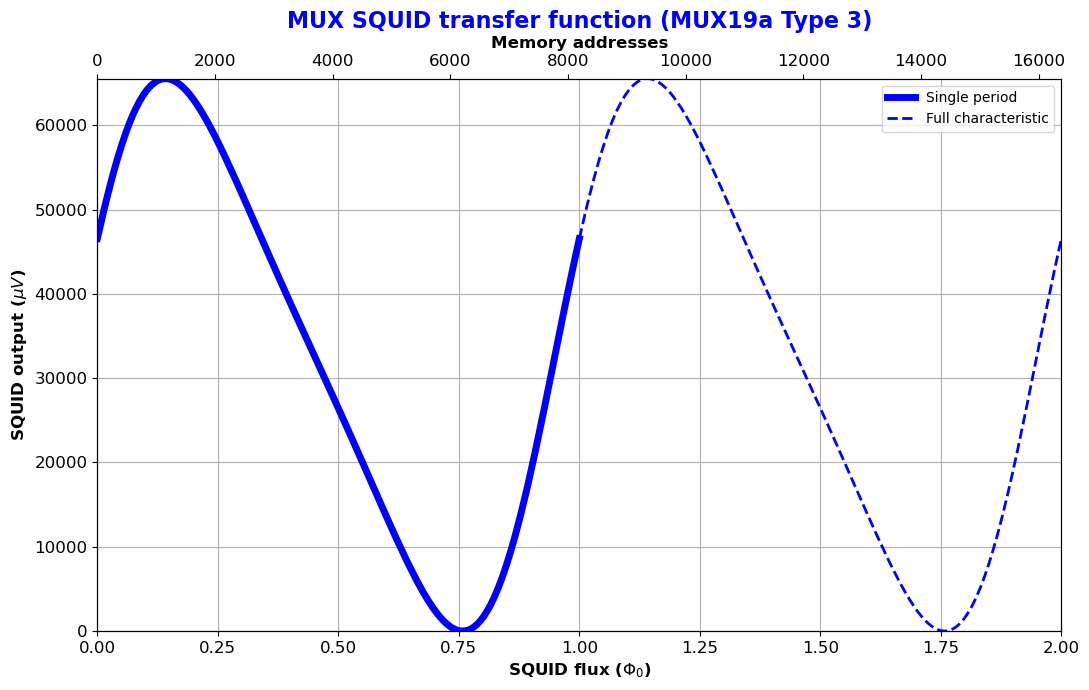

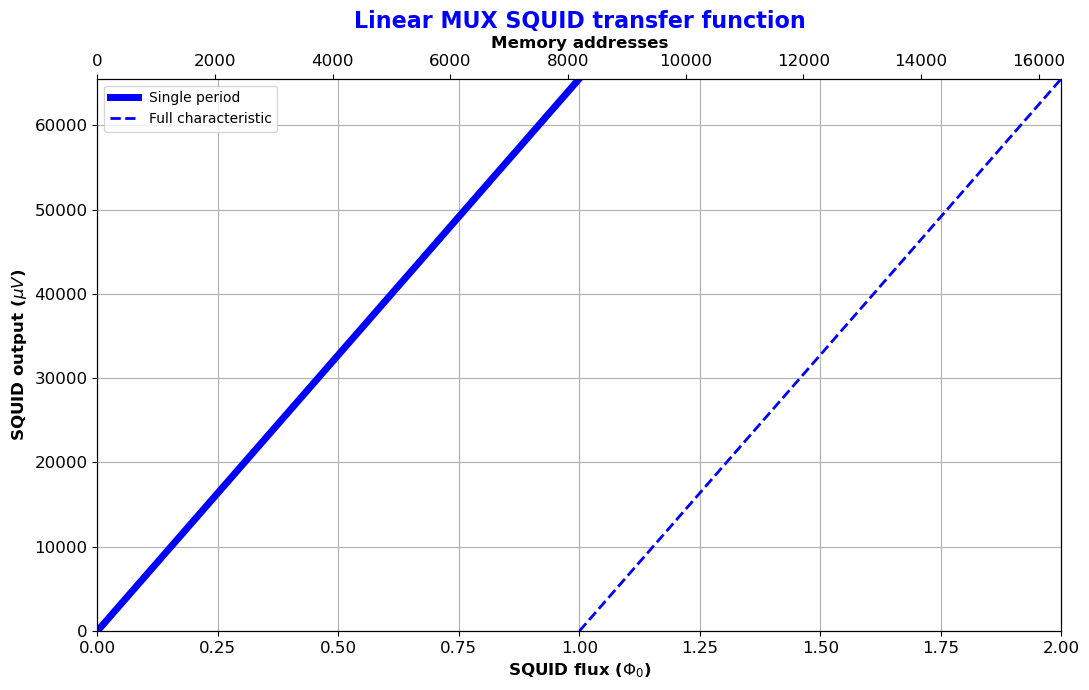

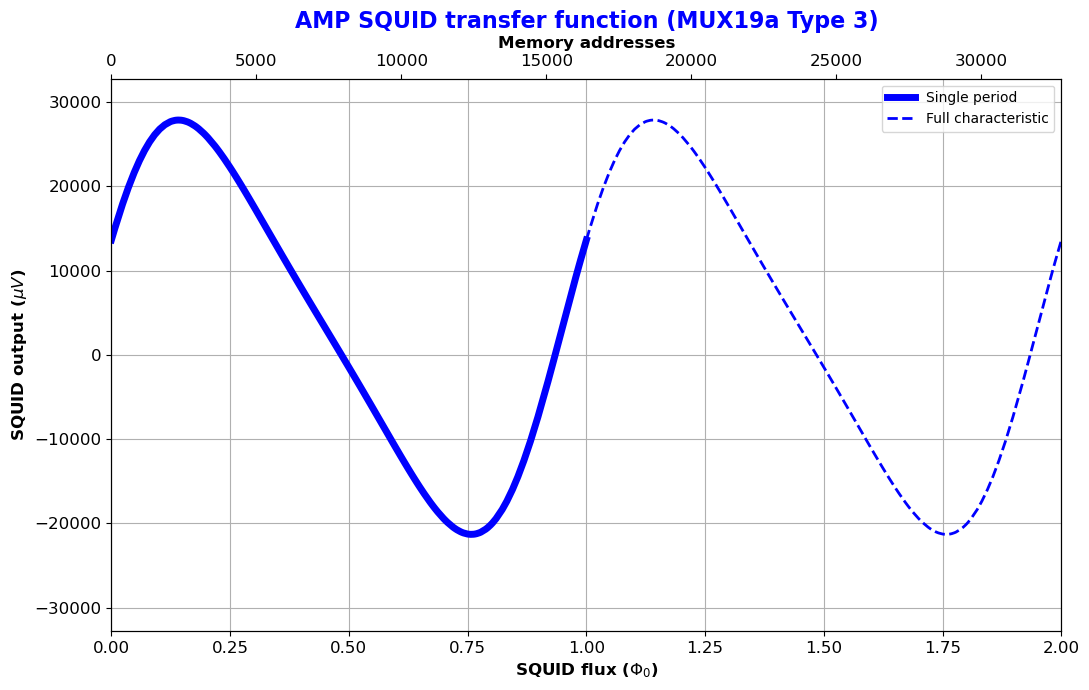

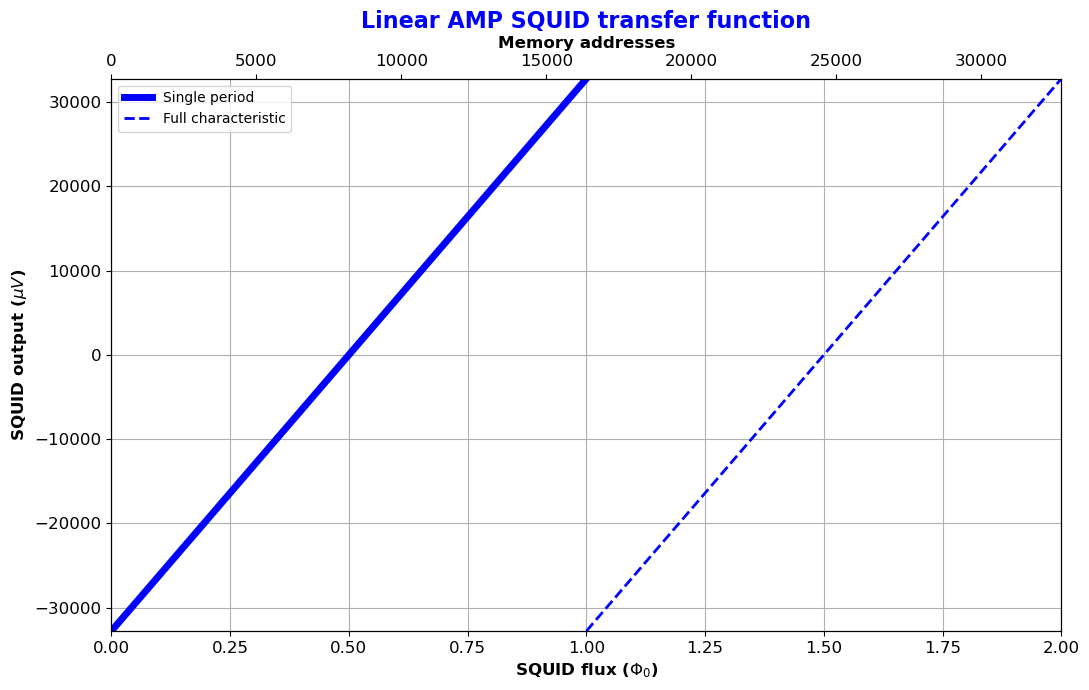

In [77]:
###################################################
# Making transfer functions
###################################################

############
# TES transfer function
############
os_factor = 16 # oversampling factor
npts = 2**11
word_length_in_bits = 16
t_tes, pulse = tes(npts, os_factor, nbits=word_length_in_bits)
t_tes_linear, pulse_linear = tf_linear(npts*os_factor, nbits=word_length_in_bits, signed=False) # for tests

# Exporting TES transfer function to a file
nom_fichier = "tes_pulse_shape.mem"
tf_to_file(pulse, word_length_in_bits, nom_fichier)
nom_fichier = "tes_linear_shape.mem"
tf_to_file(pulse_linear, word_length_in_bits, nom_fichier)


############
# TES steady state
############
ntes=64
ratio=0.90 # percentage wrt of the FSR
word_length_in_bits = 16
tes_steady = tes_steady_state(ntes, word_length_in_bits, ratio)
tes_steady_FSR = (np.ones(ntes)*(2**word_length_in_bits - 1)).astype(int)

# Exporting TES steady state to a file
nom_fichier = "tes_std_state.mem"
tf_to_file(tes_steady, word_length_in_bits, nom_fichier)
nom_fichier = "tes_std_state_FSR.mem"
tf_to_file(tes_steady_FSR, word_length_in_bits, nom_fichier)


############
# MUX SQUID transfer function
############
npts=2**13
word_length_in_bits = 16
x_mux_sq, tf_mux_sq = mux_squid(npts, nbits=word_length_in_bits, FS=1, mini=0)
plot_squid_tf(x_mux_sq, tf_mux_sq, "MUX SQUID transfer function (MUX19a Type 3)", "mux_squid_tf.png", 0, 2**word_length_in_bits)    
x_mux_sq_linear, tf_mux_sq_linear = tf_linear(npts, nbits=word_length_in_bits, signed=False) # for tests
plot_squid_tf(x_mux_sq_linear, tf_mux_sq_linear, "Linear MUX SQUID transfer function", "mux_squid_linear_tf.png", 0, 2**word_length_in_bits)    

# Exporting MUX SQUID transfer functions to a file
nom_fichier = "mux_squid_tf.mem"
tf_to_file(tf_mux_sq, word_length_in_bits, nom_fichier)
nom_fichier = "mux_squid_linear_tf.mem"
tf_to_file(tf_mux_sq_linear, word_length_in_bits, nom_fichier)


############
# MUX SQUID offset
############
nsquids=64
word_length_in_bits = 16
offset = mux_squid_offset(nsquids)

# Exporting MUX SQUID offset to a file
nom_fichier = "mux_squid_offset.mem"
tf_to_file(offset, word_length_in_bits, nom_fichier)


############
# AMP SQUID transfer function
############
npts=2**14
word_length_in_bits = 16
FS = 0.75    # amplitude wrt FSR
x_amp_sq, tf_amp_sq = mux_squid(npts, nbits=word_length_in_bits, FS=FS, mini=-2**(word_length_in_bits-1)*0.65)
# Shifting the AMP SQUID transfer function by 1/2 period
npts_roll = 0
tf_amp_sq = np.roll(tf_amp_sq, int(npts_roll))
plot_squid_tf(x_amp_sq, tf_amp_sq, "AMP SQUID transfer function (MUX19a Type 3)", "amp_squid_tf.png", \
    -2**(word_length_in_bits-1), 2**(word_length_in_bits-1))    
x_amp_sq_linear, tf_amp_sq_linear = tf_linear(npts, nbits=word_length_in_bits, signed=True) # for tests
plot_squid_tf(x_amp_sq_linear, tf_amp_sq_linear, "Linear AMP SQUID transfer function", "amp_squid_linear_tf.png", \
    -2**(word_length_in_bits-1), 2**(word_length_in_bits-1))    


# Exporting AMP SQUID transfer functions to a file
nom_fichier = "amp_squid_tf.mem"
tf_to_file(tf_amp_sq, word_length_in_bits, nom_fichier)
tf_to_xls(tf_amp_sq, "amp_squid_tf.xls")
nom_fichier = "amp_squid_linear_tf.mem"
tf_to_file(tf_amp_sq_linear, word_length_in_bits, nom_fichier)